## About
This program backtests the MACD trading strategy.
- Entry: MACD (12 period EMA - 26 period EMA) crosses above the signal line (9-period EMA) (buy on the nex day's open).
- Exit: MACD crosses below the signal line (sell on the nex day's open).

## Import modules

In [1]:
from datetime import datetime
from dateutil.relativedelta import relativedelta
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_ta as ta
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
help(ta.macd)

Help on function macd in module pandas_ta.momentum.macd:

macd(close, fast=None, slow=None, signal=None, talib=None, offset=None, **kwargs)
    Moving Average Convergence Divergence (MACD)
    
    The MACD is a popular indicator to that is used to identify a security's trend.
    While APO and MACD are the same calculation, MACD also returns two more series
    called Signal and Histogram. The Signal is an EMA of MACD and the Histogram is
    the difference of MACD and Signal.
    
    Sources:
        https://www.tradingview.com/wiki/MACD_(Moving_Average_Convergence/Divergence)
        AS Mode: https://tr.tradingview.com/script/YFlKXHnP/
    
    Calculation:
        Default Inputs:
            fast=12, slow=26, signal=9
        EMA = Exponential Moving Average
        MACD = EMA(close, fast) - EMA(close, slow)
        Signal = EMA(MACD, signal)
        Histogram = MACD - Signal
    
        if asmode:
            MACD = MACD - Signal
            Signal = EMA(MACD, signal)
          

## Define the functions for the strategy

In [3]:
def get_signal_macd(close, fast=12, slow=26, signal=9):
    """
    Pass in a time series of closing price and an optional length for 
    the short period exponential moving average (EMA), the long period EMA,
    and the signal period, returns the buying and selling dates.
    MACD trading strategy:
    - Entry: MACD crosses above the signal line (buy on the nex day's open).
    - Exit: MACD crosses below the signal line (sell on the nex day's open).  
    """    
    buy_date = []
    sell_date = []
    open_pos = False

    # Make sure that it has enough data
    if (len(close) > slow+4):
        # Calculate the MACD    
        macd = ta.macd(close, fast=fast, slow=slow, signal=signal)
        macd.dropna(inplace=True)  

        # Get the buying and selling dates
        for i in range(1,len(macd)-1):
            # Buy tomorrow if the signal started to move below the MACD
            if (macd.iloc[i,2]   < macd.iloc[i,0]) and \
              (macd.iloc[i-1,2] > macd.iloc[i-1,0]):
                buy_date.append(macd.index[i+1])
                open_pos = True
            # Sell tomorrow if the signal started to move above the MACD        
            elif (macd.iloc[i,2]   > macd.iloc[i,0]) and \
                (macd.iloc[i-1,2] < macd.iloc[i-1,0]):
                if open_pos == True:
                    sell_date.append(macd.index[i+1])
                    open_pos = False
        # Warning: remove last buy date if there is no sell date
        if open_pos == True:
            buy_date.pop()
    return buy_date, sell_date

## Define the functions for backtesting

In [4]:
def backtest_strategy(tickers, hist, start_date, end_date):
    """
    Pass in a list of ticker symbols, a dataframe containing the time series of
    closing price of each symbol, start and end dates, returns a matrix
    containing the profit/loss from each transaction and a matrix containing 
    the holding periods from each transaction.
    """ 
    matrixprofits = []
    matrixholddays = []
    for t in tickers:
        df = pd.DataFrame(hist[t].dropna())
        if (len(df) > 0):
            # Remove rows with duplicated indices
            df = df[~df.index.duplicated(keep='first')]
            
            # Obtain the buying and selling dates using Bollinger Band strategy
            buy_date, sell_date = get_signal_macd(df['Close'].dropna())
            
            # Store the average holding period
            hold_day = []
            for buy, sell in zip(buy_date, sell_date):
                hold_day.append(sell - buy)
            matrixholddays.append(hold_day)

            # Fetch the buying and selling prices
            buy_sell = pd.DataFrame({'Buy': df.loc[buy_date,'Open'], 
                                     'Sell': df.loc[sell_date,'Open']})
            buy_sell['Sell'] = buy_sell['Sell'].shift(-1)
            buy_sell.dropna(inplace=True)
            buy_sell = buy_sell.loc[start_date:end_date]

            # Store the profits
            profit = (buy_sell['Sell'] - buy_sell['Buy'])/buy_sell['Buy']
            matrixprofits.append(profit.values)

    return matrixprofits, matrixholddays

In [5]:
def calc_backtest_profit(matrixprofits, cut_loss=None, take_profit=None):
    allprofit = []
    for i in matrixprofits:
        for e in i:
            allprofit.append(e)
    if cut_loss is not None:
        allprofit = [max(cut_loss,i) for i in allprofit]
    if take_profit is not None:
        allprofit = [min(take_profit,i) for i in allprofit]        
        
    win = [i for i in allprofit if i > 0]
    loss = [i for i in allprofit if i < 0]
    prob_win = len(win)/(len(allprofit)+1e-6)
    kelly = prob_win-((1-prob_win)/
                      (np.mean(win)/np.absolute(np.mean(loss))))
    print(f'Number of transactions: {len(allprofit)}')    
    print(f'Winning probability: {np.round(100*prob_win, 2)}%')
    print(f'Mean return: {np.round(100*np.mean(allprofit), 2)}%')
    print(f'Mean profit: {np.round(100*np.mean(win), 2)}%')
    print(f'Mean loss: {np.round(100*np.mean(loss), 2)}%')    
    print(f'Kelly criterion: {np.round(100*kelly, 2)}%')    

In [6]:
def calc_backtest_effective_annual_return(matrixprofits, matrixholddays, 
                                          cut_loss=None, take_profit=None):
    allprofit = []
    for i in matrixprofits:
        for e in i:
            allprofit.append(e)
    if cut_loss is not None:
        allprofit = [max(cut_loss,i) for i in allprofit]
    if take_profit is not None:
        allprofit = [min(take_profit,i) for i in allprofit]        

    # Average holding days
    allholdday = []
    for e in matrixholddays:
        for i in e:
            allholdday.append(i.days)
    print(f'Mean holding period: {np.round(np.mean(allholdday),2)} days')
    
    # Effective annual return
    ann_return = 100* np.round(np.power(1+np.mean(allprofit),
                                        365/np.mean(allholdday))-1, 2)
    print(f'Annual effective return: {ann_return}%')

In [7]:
def calc_backtest_bet_return(matrixprofits, one_bet=100, 
                             cut_loss=None, take_profit=None):
    allprofit = []
    for i in matrixprofits:
        for e in i:
            allprofit.append(e)
    if cut_loss is not None:
        allprofit = [max(cut_loss,i) for i in allprofit]
    if take_profit is not None:
        allprofit = [min(take_profit,i) for i in allprofit]
    
    returns = 0
    for profit in allprofit:
        returns = returns + (one_bet*profit)
    print(f'If you follow the trading strategy and put {one_bet} USD for each transaction,')
    print(f'Your profit will be {np.round(returns)} USD after {len(allprofit)} number of transactions')        

In [8]:
def plot_backtest_profit_hist(matrixprofits, matrixholddays, 
                              cut_loss=None, take_profit=None):
    allprofit = []
    for i in matrixprofits:
        for e in i:
            allprofit.append(e)
    if cut_loss is not None:
        allprofit = [max(cut_loss,i) for i in allprofit]
    if take_profit is not None:
        allprofit = [min(take_profit,i) for i in allprofit]  

    # Percent profit
    allprofit = np.dot(100,allprofit)
    hist = np.histogram(allprofit, bins='auto')
    median = np.median(allprofit)
    mode = hist[1][np.argmax(hist[0])]
    plt.figure(figsize=(10,4))
    plt.hist(allprofit, bins='auto')
    plt.axvline(x=median, lw=4, ls='-.', label='median = '+ str(round(median, 1)), c='orange')
    plt.axvline(x=mode, lw=4, label='mode = '+ str(round(mode, 1)), c='red')
    plt.xlabel('Percentage return',fontsize=13)
    plt.ylabel('Counts',fontsize=13)
    plt.title('Distribution of the percentage return of all transactions')
    plt.legend();
    plt.show();

In [9]:
def calc_effective_annual_return(close, name='the asset'):
    profit = (close.iloc[-1] - close.iloc[0])/close.iloc[0]
    holdday = (close.index[-1] - close.index[0]).days
    ann_return = np.power(1+profit, (365/holdday))-1
    print(f'The effective annual return of {name} is {np.round(100*ann_return,2)}%')

## Backtest one asset

#### Download the historical data

In [10]:
ticker = 'MU'

In [11]:
start_date = datetime.now() - relativedelta(years=3)
start_date = start_date.strftime('%Y-%m-%d')
end_date = str(datetime.now().strftime('%Y-%m-%d'))

In [12]:
df = yf.download(ticker, start=start_date, end=end_date)
df_ori = df.copy()
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-08-27,51.349998,52.450001,51.169998,52.070000,52.070000,29134100
2018-08-28,52.419998,52.560001,51.470001,52.340000,52.340000,26198800
2018-08-29,52.090000,52.160000,51.299999,51.830002,51.830002,31450800
2018-08-30,51.560001,53.680000,51.400002,52.759998,52.759998,32416600
2018-08-31,52.700001,53.230000,52.220001,52.520000,52.520000,29937300
...,...,...,...,...,...,...
2021-08-19,70.139999,70.820000,69.040001,70.279999,70.279999,18022600
2021-08-20,70.139999,71.029999,69.580002,70.230003,70.230003,14594200
2021-08-23,70.839996,71.879997,68.900002,71.739998,71.739998,22265000


#### Perform the backtesting

In [13]:
df = df_ori.copy()
buy_date, sell_date = get_signal_macd(df['Close'])

#### Plot the results

In [14]:
df.ta.bbands(length=20, append=True)
df.dropna(inplace=True)
df.tail(5)

,Open,High,Low,Close,Adj Close,Volume,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
Date,,,,,,,,,,,
2021-08-19,70.139999,70.820000,69.040001,70.279999,70.279999,18022600,67.697487,75.778501,83.859514,21.327985,0.159789
2021-08-20,70.139999,71.029999,69.580002,70.230003,70.230003,14594200,67.059218,75.493001,83.926783,22.343217,0.187981
2021-08-23,70.839996,71.879997,68.900002,71.739998,71.739998,22265000,66.685519,75.265001,83.844482,22.798064,0.294568
2021-08-24,72.139999,72.690002,71.690002,71.980003,71.980003,18092700,66.464090,75.153001,83.841911,23.123256,0.317411
2021-08-25,72.790001,77.019997,72.179901,74.040001,74.040001,36552132,66.377466,75.077501,83.777535,23.176143,0.440374


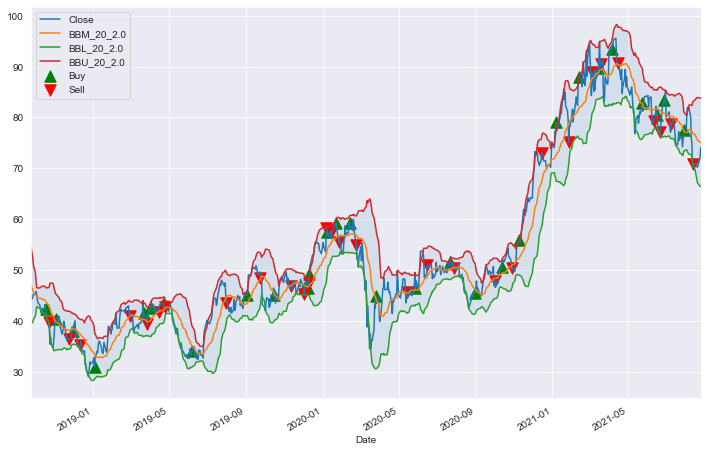

In [15]:
ax = df[['Close', 'BBM_20_2.0', 'BBL_20_2.0', 'BBU_20_2.0']].plot(figsize=(12,8))
ax.fill_between(df.index, df['BBU_20_2.0'], df['BBL_20_2.0'], alpha=0.1);
ax.scatter(buy_date, df.loc[buy_date].Close, marker='^', c='g', s=130, label='Buy')
ax.scatter(sell_date, df.loc[sell_date].Close, marker='v', c='r', s=130, label='Sell');
ax.autoscale(tight=True, axis='x');
ax.legend()
ax.grid;

#### Calculate the profit

In [16]:
buy_sell = pd.DataFrame({'Buy': df.loc[buy_date,'Open'], 
                         'Sell': df.loc[sell_date,'Open']})
buy_sell.tail(5)

,Buy,Sell
Date,,
2021-06-21,NaN,76.849998
2021-06-28,82.629997,NaN
2021-07-09,NaN,77.410004
2021-07-30,76.129997,NaN
2021-08-13,NaN,70.050003


In [17]:
buy_sell['Sell'] = buy_sell['Sell'].shift(-1)
buy_sell.dropna(inplace=True)

In [18]:
profit = (buy_sell.Sell - buy_sell.Buy)/buy_sell.Buy
win = [i for i in profit if i > 0]
pct_win = 100*len(win)/(len(profit)+1e-6)
print(f'Winning percentage: {np.round(pct_win, 2)}%')
print(f'Mean profit: {np.round(np.mean(profit*100), 2)}%')
print(f'Number of transactions: {len(profit)}')

Winning percentage: 36.67%
Mean profit: 1.14%
Number of transactions: 30


In [19]:
ret = (1 + profit).cumprod()
ret

Date
2018-10-17    0.936072
2018-11-02    0.836852
2018-11-29    0.777638
2019-01-03    0.982434
2019-03-22    0.890451
2019-04-02    0.892356
2019-04-22    0.902285
2019-06-07    1.210218
2019-09-03    1.349691
2019-10-16    1.373463
2019-12-02    1.302725
2019-12-09    1.288211
2019-12-11    1.494055
2020-01-08    1.460877
2020-01-23    1.335444
2020-02-13    1.206449
2020-03-26    1.157008
2020-05-28    1.215453
2020-07-22    1.187411
2020-08-31    1.233232
2020-10-12    1.212019
2020-11-09    1.592345
2021-01-07    1.577454
2021-02-12    1.603467
2021-03-18    1.558452
2021-04-06    1.501986
2021-05-24    1.477082
2021-06-16    1.372099
2021-06-28    1.285420
2021-07-30    1.182762
dtype: float64

In [20]:
# Store the average holding period
hold_day = []
for buy, sell in zip(buy_date, sell_date):
    hold_day.append(sell - buy)
print(f'Mean holding period: {np.mean(hold_day)}')

Mean holding period: 17 days 16:48:00


## Backtest multiple assets

#### Set the ticker symbols

In [21]:
stocks = pd.read_csv('data/nasdaq_screener_1626347395770.csv', index_col=0)
market_cap_lim = 5e10
stocks = stocks[stocks['Market Cap'] > market_cap_lim]

In [22]:
tickers = list(stocks.index)
len(tickers)

240

In [23]:
add_list = ['ARKK', 'ARKG', 'ARKF', 'ARKW', 'ARKQ', '^GSPC', '^IXIC', 'ETH-USD', 'BTC-USD']
tickers.extend(add_list)
len(tickers)

249

In [24]:
# remove weird data
unwanted_list = ['GE','TTE']
tickers = [t for t in tickers if t not in unwanted_list]
len(tickers)

247

In [25]:
benchmark = ['^GSPC', '^IXIC']

#### Obtain the historical data

In [26]:
hist_ori = pd.read_csv('data/historical_data_from_2015.csv', index_col=0, header=[0,1], parse_dates=True)

#### Perform the backtesting

In [27]:
start_date = datetime.now() - relativedelta(years=5)
data_start = start_date - relativedelta(years=1)
start_date = start_date.strftime('%Y-%m-%d')
data_start = data_start.strftime('%Y-%m-%d')
end_date = str(datetime.now().strftime('%Y-%m-%d'))
data_start, start_date, end_date

('2015-08-26', '2016-08-26', '2021-08-26')

In [28]:
hist = hist_ori.loc[data_start:end_date]

The effective annual return of ^GSPC is 15.46%
The effective annual return of ^IXIC is 23.11%


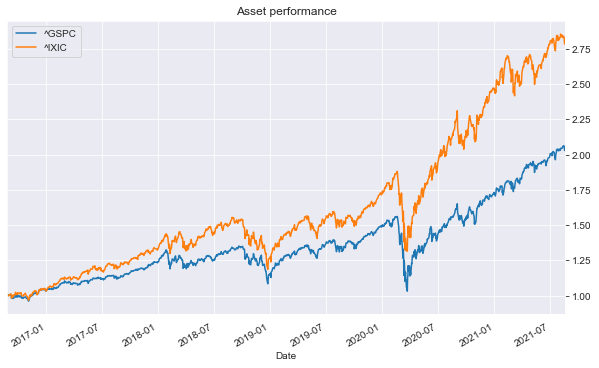

In [29]:
df2 = pd.DataFrame()
for idx in benchmark:
    df2[idx] = hist.loc[start_date:end_date][idx]['Close'].dropna()
    calc_effective_annual_return(df2[idx], name=idx)
ax = (df2/df2.iloc[0]).plot(figsize=(10,6),title='Asset performance')
ax.autoscale(tight=True, axis='x')
ax.yaxis.tick_right()

macd-------------------------------------------
Number of transactions: 11706
Winning probability: 42.55%
Mean return: 1.22%
Mean profit: 7.03%
Mean loss: -3.09%
Kelly criterion: 17.29%
Mean holding period: 18.45 days
Annual effective return: 27.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 14337.0 USD after 11706 number of transactions


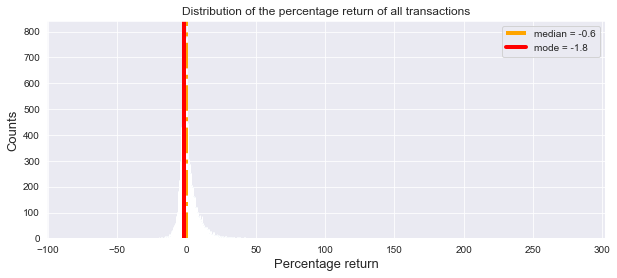

macd cut_loss----------------------------------
Number of transactions: 11706
Winning probability: 42.55%
Mean return: 1.53%
Mean profit: 7.03%
Mean loss: -2.57%
Kelly criterion: 21.59%
Mean holding period: 18.45 days
Annual effective return: 35.0%
If you follow the trading strategy and put 100 USD for each transaction,
Your profit will be 17860.0 USD after 11706 number of transactions


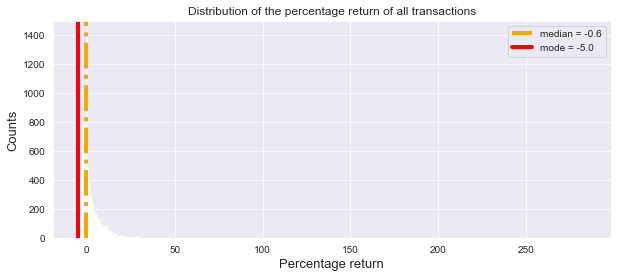

In [30]:
st = 'macd'
print(f'{st}-------------------------------------------')
matrixprofits, matrixholddays = backtest_strategy(tickers, hist, start_date, end_date)
calc_backtest_profit(matrixprofits)
calc_backtest_effective_annual_return(matrixprofits, matrixholddays)
calc_backtest_bet_return(matrixprofits, one_bet=100)
plot_backtest_profit_hist(matrixprofits, matrixholddays)
print(f'{st} cut_loss----------------------------------')
calc_backtest_profit(matrixprofits, cut_loss=-0.05)
calc_backtest_effective_annual_return(matrixprofits, matrixholddays, cut_loss=-0.05)
calc_backtest_bet_return(matrixprofits, one_bet=100, cut_loss=-0.05)
plot_backtest_profit_hist(matrixprofits, matrixholddays, cut_loss=-0.05)